# **CIS 545 Project**

Aim of this project is to try and predict Amazon Star Ratings based on the content of the review. The dataset has 100,000 reviews. 

**Layout of the Project**

1. Installing requried packages and dataset
2. Data collection and Extraction
3. Feature Extraction
4. Dataset Analysis
5. Building the model
6. Analysis of the models

**1.1 Installing required packages**

In [0]:
# install stuff
%%capture
!pip install -U gensim
!pip install urllib2

In [0]:
import gensim
gensim.__version__

'3.8.1'

In [0]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms

from datetime import *
from operator import itemgetter
from datetime import datetime

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

import os

In [0]:
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment import SentimentAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
from google.colab import drive
from google.colab import files
import io

**1.2 Uploading the csv dataset** 

The final dataset which used by the classifier to predict the star ratings is in an csv file. 

Please follow the steps below to install the csv file titled **"Final_DataSet-545.csv"**

The csv file will contain 10 columns (Index, Review, Ratings, Postive_Sentiment, Postive_Sentiment, Postive_Sentiment, Review Length, Date_of_Review, Holiday_Season, bag_of_words)

**This cell need not be run.**

In [0]:
#Used to save pandas dataframe to google drive

from google.colab import drive
drive.mount('drive')
df.to_csv('data.csv')
!cp data.csv drive/My\ Drive/

**Please run this cell**

Please click on the "Choose Files" button and browse to the location of the csv file. (It will take 5-10 minutes for the file to upload)

Note: Incase of any error please **rerun** this cell again.


In [0]:
from google.colab import files
uploaded = files.upload()

Saving Final_DataSet-545.csv to Final_DataSet-545.csv


**2. Data collection and Extraction**

Although we have already downloaded the entire dataset of 100,000 records. We will still create a dummy dataframe of 10 reviews so that we can go through the steps that were followed to create the actual dataset.

2.1

The first step is to download the dataset from the web.

In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

2.2

Once we get the data from the web, we use the "Gensim" library to load the reviews as a dictionary. We also get the time stamp of each review and the actual reviews. 

In [0]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

2.3 

Now that we have all the required data, we need to write a few helper funtions which will give us the data in the format that is required for our analysis.

1st Helper Function "lookup_docs"- Returns a document given an index and corpus

The gensim library represents everything in a sparse way. It optimizes space by not reading large amounts of data through memory but rather through the user's pipeline. Due to these optamization techniques, it is not possible to directly access the dataset by index. However, that is such a useful feature and would be used time and again to get the actual words from the dataset. Hence the next function (lookup_docs) implements accessing a corpus by index and returning the corresponding text.


In [0]:
def lookup_docs(corpus, indices):  
    docs=[]
    for index,value in enumerate(corpus):
      if index in indices:
        docs.append(value)
    return docs

In [0]:
print(lookup_docs(reviews_bow,[0]))

[[(0, 1.0), (1, 1.0), (2, 1.0), (3, 2.0), (4, 1.0), (5, 1.0), (6, 5.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 3.0), (13, 1.0), (14, 2.0), (15, 1.0), (16, 1.0), (17, 1.0), (18, 1.0), (19, 1.0), (20, 1.0), (21, 1.0), (22, 1.0), (23, 1.0), (24, 4.0), (25, 1.0), (26, 2.0), (27, 1.0), (28, 1.0), (29, 2.0), (30, 1.0), (31, 1.0), (32, 1.0), (33, 1.0), (34, 1.0), (35, 1.0), (36, 1.0), (37, 1.0), (38, 1.0), (39, 1.0), (40, 1.0), (41, 1.0), (42, 1.0), (43, 1.0), (44, 2.0), (45, 1.0), (46, 2.0), (47, 1.0), (48, 1.0), (49, 1.0), (50, 1.0), (51, 1.0), (52, 1.0), (53, 1.0), (54, 1.0), (55, 2.0)]]


From the "lookup_docs" function, we see how documents are represented in a gensim corpus. In each review, gensim stores a tuple of size 2 for each distinct word in the review. The first number in the tuple is the index of the word in the dictionary and the second number in the tuple is the count of the times that word appeared in that review.

Now that we have the gensim bag of words document and its corresponding dictionary. We can find the actual text that is represented by the bag of words. 

2nd Helper Function "translate_review"- Returns the actual english words corresponding to gensim bag of words.


In [0]:
def translate_review(review, reviews_dict):
    result=[]
    for i in review:
      result.append((reviews_dict[i[0]]+ " ") * int(i[1]))
    result=''.join(result)
    return result

All of these helper functions are written to create a pandas dataframe which will be used by the machine learning algorithm to predict the star reviews.

The size of the dummy pandas dataframe is stored in the variable defined below ("df_size"). 

Note: Running some of these functions are computionally very heavy and hence we have limited the size of the dataframe to **10** records. The dataframe generated by running the next section is meant only to show how the helper functions were used to create the dataframe. 

**The actual dataframe consisting of 100,000 records was already installed at the start of this notebook. (Filename: Final_DataSet-545.csv)**

The next few steps are only for the purposes of creating the dummy dataframe

In [0]:
# setting the size of the dummy dataframe
df_size=np.arange(0,10)
df_size=list(df_size)

Here, we use the previous functions to read the gensim bag of words-> get the translated review and finally store it as a tuple corresponding to the translated review and the index of that review in the corpus.

In [0]:
translated_reviews=[]
bag_of_words=[]
for i, value in enumerate(df_size):
  print("Currently Processing Review Number:",value+1)
  lookup_review= lookup_docs(reviews_bow, [value])
  bag_of_words.append(lookup_review)
  temp = translate_review(lookup_review[0],reviews_dict)
  translated_reviews.append((i,temp))

Currently Processing Review Number: 1
Currently Processing Review Number: 2
Currently Processing Review Number: 3
Currently Processing Review Number: 4
Currently Processing Review Number: 5
Currently Processing Review Number: 6
Currently Processing Review Number: 7
Currently Processing Review Number: 8
Currently Processing Review Number: 9
Currently Processing Review Number: 10


We finally venture into creating our first basic Pandas Dataframe which will just contain the translated review (obtained from the Gensim BoW) and the star rating associated with that review. 

Run the cell below to see the pandas dataframe

In [0]:
first_index= df_size[0]
last_index = df_size[-1]

#creating a list of only 'df_size' number of reviews
y_temp = y[first_index: last_index+1]

df = pd.DataFrame(translated_reviews,y_temp) 
df= df.reset_index()
df = df.drop(columns=0)
df =  df.rename(columns={"index": "Ratings", 1: "Review"})
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

display(df)

,Review,Ratings
0,abl aggress also apart apart aussi away ball b...,1
1,bark bark bark clean day dish dish dog dump fi...,1
2,better disappoint money think wast absorb abso...,1
3,just will full next one price add anyth bottl ...,1
4,left now either go goe light light nowher plu ...,1
5,just littl day day use bought problem now time...,1
6,ball larg lb terrier dog dog within boston che...,1
7,better come come tri will will replac return r...,1
8,come hard tri dog break care kick leg near,1
9,tri will dog return use use use bought bought ...,1


**3. Feature Extraction**

In this section we are going to try and create features from the information that we already have. These features might help us make better predictions!

3.1 Sentiment Analysis of the review

The first feature we are going to generate is getting the overall postive/neutral/negative sentiment of the review. The sentiment of the review should have a high correlation with the star rating.
The intuition to generate this feature is fairly obvious. It is logical for us to assume that a 1 star review will contain more negative words and hence have a more overall negative sentiment than a 5 star review.  

Our basic objective in the next function is to use the NLTK SentimentIntensityAnalyzer to predict what is the probability of the review being Positive/Neutral/Negative. It is very important to note that since our reviews are **not in order** we will lose considerable amount of meaning from the review. 

Consider the following sentence: "The bag of chips was not great". If any human reads this sentence they will come to the conculsion that the chips was probably not very good. Here the word "great" (which is usually a positive word) is preceded with a "not" and hence this "not" makes the positive word "great" to a negative word. A computer might to be able to come to a similar conclusion if it reads the same sentence. 

Now, suppose if I change the sentence to "Chips great the bag of not was ". Now if I ask you to infer the meaning of this sentence you might rearrange it to the original form and conclude that the chips was not great. But if I ask someone else (maybe someone who's first language is not English) to read the sentence they might read the sentence and infer that the chips was good but the "bag" that the chips came in was bad. (It's simple enough isn't it? "Great" is next to chips so the chips is great and "not" is next to bag so the bag is probably "not great")

This is the kind of subtlety that we humans can understand but a machine probably can't (Atleast not right now...I hope). 

The jist of the above example is that when words are placed out of order (which is what a bag of words does) then the sentence loses a lot of meaning. Hence we may occasionally see a poor review having a higher positive sentiment than a negative sentiment. 

We will store each of the three sentiments in a list and later create pandas features from these lists.

In [0]:
sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()

#storting the sentiment scores of postive/neutral/negative sentiments in lists
pos_word_score=[]
neu_word_score=[]
neg_word_score=[]

for i, word in enumerate(translated_reviews):

    temp= sid.polarity_scores(word[1])
    pos_word_score.append(temp['pos'])
    neu_word_score.append(temp['neu'])
    neg_word_score.append(temp['neg']) 

In [0]:
# Adding new features to our dataframe corresponding to the sentiment analysis that we performed in the previous cell

df['Positive_Sentiment'] =pos_word_score
df['Neutral_Sentiment'] =neu_word_score
df['Negative_Sentiment'] =neg_word_score
display(df)

,Review,Ratings,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment
0,abl aggress also apart apart aussi away ball b...,1,0.160,0.690,0.149
1,bark bark bark clean day dish dish dog dump fi...,1,0.116,0.756,0.128
2,better disappoint money think wast absorb abso...,1,0.239,0.527,0.234
3,just will full next one price add anyth bottl ...,1,0.000,0.881,0.119
4,left now either go goe light light nowher plu ...,1,0.119,0.881,0.000
5,just littl day day use bought problem now time...,1,0.080,0.717,0.203
6,ball larg lb terrier dog dog within boston che...,1,0.073,0.927,0.000
7,better come come tri will will replac return r...,1,0.116,0.849,0.035
8,come hard tri dog break care kick leg near,1,0.276,0.603,0.121
9,tri will dog return use use use bought bought ...,1,0.118,0.882,0.000


3.2 Review Length

We are now going to make some claims (i.e. create some hypothesis) in this section and the next and later on (Section 4) we will analyze whether those claims were correct or not.

My first assumption is that people give very long reviews when they are experiencing extreme emotions. Assume for a moment that I am right in my assumption, that when someone is overly expressive, they are experiencing extremes of emotions (either they are really happy or really angry). We try to put this hypothesis to the test by claiming that whenever people are really happy/sad with a product they will write a longer review. Hence, we expect the average length of the review for 1 and 5 star ratings to be the longest and star rating 3 to be the shortest. 

In [0]:
length_of_review=[]

# code to iterate through the reviews and count the length of each review and it's corresponding star rating
for i, word in enumerate(translated_reviews):

    word_length = len(word[1])
    length_of_review.append(word_length)

df['Review_Length'] =length_of_review
display(df)       

,Review,Ratings,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment,Review_Length
0,abl aggress also apart apart aussi away ball b...,1,0.160,0.690,0.149,415
1,bark bark bark clean day dish dish dog dump fi...,1,0.116,0.756,0.128,195
2,better disappoint money think wast absorb abso...,1,0.239,0.527,0.234,334
3,just will full next one price add anyth bottl ...,1,0.000,0.881,0.119,157
4,left now either go goe light light nowher plu ...,1,0.119,0.881,0.000,82
5,just littl day day use bought problem now time...,1,0.080,0.717,0.203,232
6,ball larg lb terrier dog dog within boston che...,1,0.073,0.927,0.000,79
7,better come come tri will will replac return r...,1,0.116,0.849,0.035,568
8,come hard tri dog break care kick leg near,1,0.276,0.603,0.121,43
9,tri will dog return use use use bought bought ...,1,0.118,0.882,0.000,235


3.3 Time of the Review

My next claim is that people become very happy around the holidays (Christmas, Thanksgiving, 4th of July...Valentine's Day?) and the happiness rubs off on them and they tend to become a tad nicer to the Amazon Seller who tried to ripped them off. If this is true, then there must be a spike in the average star reviews around the time of the holidays. We will check later on if this claim is true...

To carry out this experiment, we first need to extract the actual date of the review from the "review_times" array and then find the average star ratings during the holiday season to see if people are truly happy during the holidays.

Note: We currently have the date stored as a timestamp and not in the date format familiar to us (i.e. YYYY-MM-DD). Hence, we will first convert the timestamp to human readable date format and then check if that date falls in the holiday season or not.

In [0]:
def convert_times(reviews_times):
    # Iterating through reviews_time list and converting the timestamp to actual date of the format YYYY-MM-DD
    result=[]
    for i in reviews_times:
          date = datetime.fromtimestamp(i)
          result.append(date)
    return result

3.4 Holiday Season

Now that we have the date in the approriate format, we will check and see if someone has bought a product during the holiday season or not (if they have then we will set the feature 'Holiday_Season' to True for that review).

We have taken 3 holiday periods for our analysis: 


1.   Valentine's Day + President's Day week  (10th February- 22nd February)
2.   4th of July week (3rd July- 7th July)
2.   Thanksgiving week + Entire month of December + 1st week of the New Year  (23rd November- 7th January)





In [0]:
holiday_season = convert_times(reviews_times)
df['Date_of_Review'] = holiday_season[first_index : last_index +1]

# if a date falls in any of the above mentioned holiday periods then feature "Holiday_Season" will be set to TRUE
df.loc[df.Date_of_Review.between('2002-02-10', '2002-02-22') | df.Date_of_Review.between('2002-07-03', '2002-07-07') | df.Date_of_Review.between('2002-11-24', '2003-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2003-02-10', '2003-02-22') | df.Date_of_Review.between('2003-07-03', '2003-07-07') | df.Date_of_Review.between('2003-11-24', '2004-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2004-02-10', '2004-02-22') | df.Date_of_Review.between('2004-07-03', '2004-07-07') | df.Date_of_Review.between('2004-11-24', '2005-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2005-02-10', '2005-02-22') | df.Date_of_Review.between('2005-07-03', '2005-07-07') | df.Date_of_Review.between('2005-11-24', '2006-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2006-02-10', '2006-02-22') | df.Date_of_Review.between('2006-07-03', '2006-07-07') | df.Date_of_Review.between('2006-11-24', '2007-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2007-02-10', '2007-02-22') | df.Date_of_Review.between('2007-07-03', '2007-07-07') | df.Date_of_Review.between('2007-11-24', '2008-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2008-02-10', '2008-02-22') | df.Date_of_Review.between('2008-07-03', '2008-07-07') | df.Date_of_Review.between('2008-11-24', '2009-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2009-02-10', '2009-02-22') | df.Date_of_Review.between('2009-07-03', '2009-07-07') | df.Date_of_Review.between('2009-11-24', '2010-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2010-02-10', '2010-02-22') | df.Date_of_Review.between('2010-07-03', '2010-07-07') | df.Date_of_Review.between('2010-11-24', '2011-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2011-02-10', '2011-02-22') | df.Date_of_Review.between('2011-07-03', '2011-07-07') | df.Date_of_Review.between('2011-11-24', '2012-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2012-02-10', '2012-02-22') | df.Date_of_Review.between('2012-07-03', '2012-07-07') | df.Date_of_Review.between('2012-11-24', '2013-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2013-02-10', '2013-02-22') | df.Date_of_Review.between('2013-07-03', '2013-07-07') | df.Date_of_Review.between('2013-11-24', '2014-01-07'),'Holiday_Season'] =True
df.loc[df.Date_of_Review.between('2014-02-10', '2014-02-22') | df.Date_of_Review.between('2014-07-03', '2014-07-07') | df.Date_of_Review.between('2014-11-24', '2015-01-07'),'Holiday_Season'] =True

df['Holiday_Season']=df['Holiday_Season'].fillna('False')
display(df)

,Review,Ratings,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment,Review_Length,Date_of_Review,Holiday_Season
0,abl aggress also apart apart aussi away ball b...,1,0.160,0.690,0.149,415,2012-05-06,False
1,bark bark bark clean day dish dish dog dump fi...,1,0.116,0.756,0.128,195,2014-04-07,False
2,better disappoint money think wast absorb abso...,1,0.239,0.527,0.234,334,2012-07-17,False
3,just will full next one price add anyth bottl ...,1,0.000,0.881,0.119,157,2014-07-14,False
4,left now either go goe light light nowher plu ...,1,0.119,0.881,0.000,82,2013-05-16,False
5,just littl day day use bought problem now time...,1,0.080,0.717,0.203,232,2013-06-17,False
6,ball larg lb terrier dog dog within boston che...,1,0.073,0.927,0.000,79,2013-10-16,False
7,better come come tri will will replac return r...,1,0.116,0.849,0.035,568,2012-08-27,False
8,come hard tri dog break care kick leg near,1,0.276,0.603,0.121,43,2013-10-24,False
9,tri will dog return use use use bought bought ...,1,0.118,0.882,0.000,235,2014-01-16,False


3.5 Bag of words

We had previously generated the Bag of Words of the reviews and we are now appending that feature to that dataset.

In [0]:
df['bag_of_words'] = bag_of_words

**Displaying the final shape of the dataframe. The actual dataset of 100,000 records will have the same shape**

In [0]:
display(df)

,Review,Ratings,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment,Review_Length,Date_of_Review,Holiday_Season,bag_of_words
0,abl aggress also apart apart aussi away ball b...,1,0.160,0.690,0.149,415,2012-05-06,False,"[[(0, 1.0), (1, 1.0), (2, 1.0), (3, 2.0), (4, ..."
1,bark bark bark clean day dish dish dog dump fi...,1,0.116,0.756,0.128,195,2014-04-07,False,"[[(56, 3.0), (57, 1.0), (58, 1.0), (59, 2.0), ..."
2,better disappoint money think wast absorb abso...,1,0.239,0.527,0.234,334,2012-07-17,False,"[[(7, 1.0), (15, 1.0), (31, 1.0), (47, 1.0), (..."
3,just will full next one price add anyth bottl ...,1,0.000,0.881,0.119,157,2014-07-14,False,"[[(23, 1.0), (55, 1.0), (63, 1.0), (67, 1.0), ..."
4,left now either go goe light light nowher plu ...,1,0.119,0.881,0.000,82,2013-05-16,False,"[[(99, 1.0), (133, 1.0), (143, 1.0), (144, 1.0..."
5,just littl day day use bought problem now time...,1,0.080,0.717,0.203,232,2013-06-17,False,"[[(23, 1.0), (28, 1.0), (58, 2.0), (79, 1.0), ..."
6,ball larg lb terrier dog dog within boston che...,1,0.073,0.927,0.000,79,2013-10-16,False,"[[(6, 1.0), (25, 1.0), (26, 1.0), (46, 1.0), (..."
7,better come come tri will will replac return r...,1,0.116,0.849,0.035,568,2012-08-27,False,"[[(7, 1.0), (12, 2.0), (51, 1.0), (55, 2.0), (..."
8,come hard tri dog break care kick leg near,1,0.276,0.603,0.121,43,2013-10-24,False,"[[(12, 1.0), (21, 1.0), (51, 1.0), (60, 1.0), ..."
9,tri will dog return use use use bought bought ...,1,0.118,0.882,0.000,235,2014-01-16,False,"[[(51, 1.0), (55, 1.0), (60, 1.0), (73, 1.0), ..."


**4. Dataset Analysis**

Now that we have seen how we got the dataset, we will use the 100,000 Amazon Review dataset and try to predict star ratings.

The last 5 rows of the actual dataframe is displayed below.

In [0]:
import io

# Please make sure that the filename in "uploaded" is the same as the excel that you downloaded
df2 = pd.read_csv(io.BytesIO(uploaded['Final_DataSet-545.csv']))
df2 = df2.drop(columns=['Unnamed: 0'])

display(df2.tail())

,Review,Ratings,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment,Review_Length,Date_of_Review,Holiday_Season,bag_of_words
99995,come tri will replac worth time work batteri m...,5,0.176,0.824,0.000,101,4/4/2013,False,"[[(12, 1.0), (51, 1.0), (55, 1.0), (72, 1.0), ..."
99996,great use water water water problem straight e...,5,0.253,0.625,0.122,263,9/21/2010,False,"[[(20, 1.0), (79, 1.0), (80, 3.0), (110, 1.0),..."
99997,think one now go get around thing even small y...,5,0.189,0.811,0.000,106,5/12/2013,False,"[[(47, 1.0), (105, 1.0), (133, 1.0), (144, 1.0..."
99998,abl littl work still well product realli remai...,5,0.130,0.683,0.186,80,3/5/2013,False,"[[(0, 1.0), (28, 1.0), (142, 1.0), (175, 1.0),..."
99999,better sinc use problem get top need help back...,5,0.335,0.449,0.216,135,7/27/2012,False,"[[(7, 1.0), (75, 1.0), (79, 1.0), (110, 1.0), ..."


Before we start answering our claims that we made from the previous section. We need to handle **missing values** that occured in our dataset. 

The cell below finds those indices which had missing values and hence non existent BoW and replaces them with an "(empty)" review. 

Finally, all the reviews are stored in a list called "documents"

In [0]:
documents = []
missing_values=[]
X=df2['Review']
for i,j in enumerate(X):
  if isinstance(j, float):
    missing_values.append(i)
    documents.append("")
  else:
    documents.append(j)  
print("List of indices with missing values are:", missing_values)

List of indices with missing values are: [12509, 13075, 13113, 13542, 14031, 14148, 15177, 18256, 18370, 21873, 21897, 21991, 32258, 38526, 39041, 42428, 44725, 50840, 55156, 60792, 62032, 62594, 64402, 65105, 66696, 69351, 69771, 70254, 77158, 79352, 84942, 87516, 95195, 99710]


We previously made a claim that people tend to give nicer reviews during the holidays. Run the cell below which will display a bar graph which we can use to accept/reject our claim.

Text(0.5, 1.0, 'Holiday Season vs Rating')

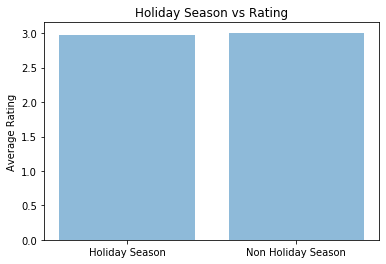

In [0]:
Reviews_Holiday_Season=df2[df2['Holiday_Season']]['Ratings'].mean()
Reviews_Non_Holiday_Season=df2[df2['Holiday_Season']==False]['Ratings'].mean()

Holiday_Review_Comparison=[Reviews_Holiday_Season,Reviews_Non_Holiday_Season]
objects = ('Holiday Season','Non Holiday Season')

y_pos = np.arange(len(objects))
plt.bar(y_pos, Holiday_Review_Comparison, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average Rating')
plt.title('Holiday Season vs Rating')

From the bar graph we see that the average rating given by users during the Holiday and Non Holiday Season are identical. Hence our claim that "people give nicer during holidays" can be rejected.

The next claim that we made was that people tend to write longer reviews when they are experiencing extreme emotions. Run the cell below to see if this is true.

Text(0.5, 1.0, 'Review_Length vs Rating')

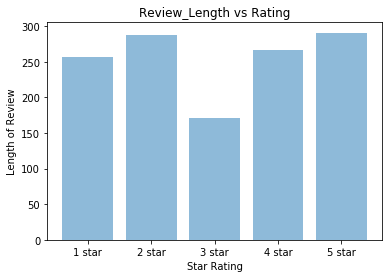

In [0]:
L1= df2[df2['Ratings']==1]['Review_Length'].mean()
L2= df2[df2['Ratings']==2]['Review_Length'].mean()
L3= df2[df2['Ratings']==3]['Review_Length'].mean()
L4= df2[df2['Ratings']==4]['Review_Length'].mean()
L5= df2[df2['Ratings']==5]['Review_Length'].mean()


Review_Length_Comparison=[L1,L2,L3,L4,L5]
objects = ('1 star','2 star','3 star', '4 star' ,'5 star')

y_pos = np.arange(len(objects))
plt.bar(y_pos, Review_Length_Comparison, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Length of Review')
plt.xlabel('Star Rating')
plt.title('Review_Length vs Rating')

From the bar chart we see that the shortest reviews are written for a star rating of 3 stars. Hence our claim cannot be rejected. People do tend to short reviews when they are just satisfied with their project and do not have a very strong opinion on it. The highest reviews lengths are given to product with 2 and 5 stars (which does seem reasonable). 

We also calculated the sentiment of each review. Let's try to see what is the overall sentiment of the dataset.

In [0]:
Avg_Pos_Sentiment = df2['Positive_Sentiment'].mean()
Avg_Neu_Sentiment = df2['Neutral_Sentiment'].mean()
Avg_Neg_Sentiment = df2['Negative_Sentiment'].mean()

print("Average Positive Sentiment of dataset:",Avg_Pos_Sentiment)
print("Average Neutral Sentiment of dataset:",Avg_Neu_Sentiment)
print("Average Negative Sentiment of dataset:",Avg_Neg_Sentiment)

Average Positive Sentiment of dataset: 0.2300957699999985
Average Neutral Sentiment of dataset: 0.7038508100000255
Average Negative Sentiment of dataset: 0.06571150999999988


We see a very high **Neutral** sentiment in that dataset. This can be explained by people subtly expressing their positive/negative opinions which could not be captured by the NLTK Sentiment Analyzer due to the **Random Ordering of Words**

**Count Vectorizer**

We are almost done with all our feature engineering and analysis of the dataset. The last thing for us to do is to convert our textual data into a numeric form. This is an important step because machine learning algorithms expect numeric data to work on rather than text. Hence to perform this conversion we will use CountVectorizer() function.

We will be creating vectors that have a dimensionality restricted to a maximum of 3000 worda. If the text data contains that word then we will put a one in that dimension. Every time we encounter that word again, we will increase the count, leaving 0s everywhere we did not find the word even once.

The result of this will be very large matrix which will give us the word frequency count in every document. 

The CountVectorizer is a way to tokenize a collection of text documents and build a vocabulary of known words. It also helps to encode new documents using that vocabulary. We will pass all our reviews to this CountVectorizer and it will build a sparse matrix which can be used by the machine learning classfier to classify the reviews. 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english',max_features=3000)
X = vectorizer.fit_transform(documents).toarray()
print("Encoded Count Vectorizer Matrix")
print(X)

Encoded Count Vectorizer Matrix
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Finally, we will create our training feature dataframe (X) and the label dataframe (y). 

In [0]:
X=pd.DataFrame(X)
X['Holiday_Season'] =df2['Holiday_Season']
X['Positive_Sentiment'] = df2['Positive_Sentiment']
X['Neutral_Sentiment'] = df2['Neutral_Sentiment']
X['Negative_Sentiment'] = df2['Negative_Sentiment']
X['Review_Length'] = df2['Review_Length']
y= df2['Ratings']

In [0]:
# performing 80-20 Train Test Split on the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**5. Building the model**

Now that we have our training and test dataset we will use sklearn library to build 3 models to run on our dataset.


1.   Random Forest Classifier 
2.   Naive Bayes
3.   Logistic Regression

In [0]:
classifiers = [
    RandomForestClassifier(),
    GaussianNB(),
    LogisticRegression()
    ]

names_of_classifiers=["Random Forest","Naive Bayes","Logistic Regression"]

In [0]:
# code to create, fit and predict the star ratings using the Machine Learning classifiers that were listed above

acc_score=[]
f1_scores=[]
p_scores=[]
r_scores=[]
for index,clf in enumerate(classifiers):
    
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    y_pred = clf.predict(X_test)
    acc= accuracy_score(y_test, y_pred)
    acc_score.append(acc)
    print("Accuracy: {:.4%}".format(acc))
    
    if index == len(classifiers) - 1:
      cm=confusion_matrix(y_test,y_pred)
      f1_scores=f1_score(y_test, y_pred, average=None)
      p_scores=precision_score(y_test, y_pred, average=None)
      r_scores=recall_score(y_test, y_pred, average=None)
   
print("="*30)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier
****Results****
Accuracy: 75.5750%
GaussianNB
****Results****
Accuracy: 70.0850%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression
****Results****
Accuracy: 85.0950%


**6. Analysis of the models**

**6.1 Accuracy Plot**

Plot showing the accuracies of the different classifiers. 

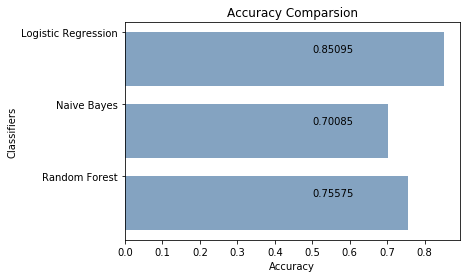

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

x = names_of_classifiers
acc = acc_score

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(acc))  # the x locations for the groups
ax.barh(ind, acc, width, color=(0.2, 0.4, 0.6, 0.6))
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(acc):
    #ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    temp = float(v)
    ax.text(0.5, i+0.1,str(v))
plt.title('Accuracy Comparsion')
plt.xlabel('Accuracy')
plt.ylabel('Classifiers')      
#plt.show()
plt.savefig(os.path.join('test.png'), dpi=300, format='png', bbox_inches='tight') 

It can clearly be seen that based on the accuracy **Logistic Regression** is performing better than the other classifers. (**This claim is only specific to the analysis performed in this notebook.**)

**6.2 Learning Curve**

A learning curve is a plot that shows training size on the x-axis and learning or improvement (in accuracy) on the y-axis. 

Now that we have established that **Logistic Regression** is performing better than other models **(strictly on the basis of the analysis that we have performed)**, we will see how training size affects the learning of the model. This will take 10 minutes to run.

**Note: Please ignore the warnings and scroll to the end of the warnings to see the curve.**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify th

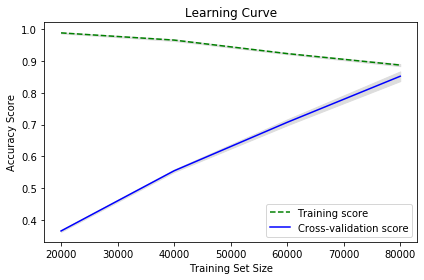

In [0]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                
                                                        # 4 different sizes of the training set
                                                        train_sizes=np.linspace(0.25, 1.0, 4))
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="g",  label="Training score")
plt.plot(train_sizes, test_mean, color="b", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

From the learning curve we can see that the training loss remains steady and then slowly reduces with increase in number of traning samples. This is not very insightful on its own, but when we combine it with the validation curve we see something interesting. The validation set accuracy increases linearly when number of training samples increases. This is because, when our traning set had very few samples the model was **underfitting**. The training set accuracy was high because it had to learn only from a few features but it performed very poorly on the validation set because the model had not seen enough samples for it to generalize well. Later, as we kept increasing the size of the traning set, the model was able to generalize well and while it did lead to drop in training accuracy, the jump in cross validation accuracy was something which was much more important for us. At the end, the model achieved equally good accuracy for both the training and validation set indicating that it had fit well to the data. 

**6.3 Confusion Matrix**

For our last piece of analysis, we plot a confusion matrix so that we can clearly see how well the model did across all the 5 classes. 

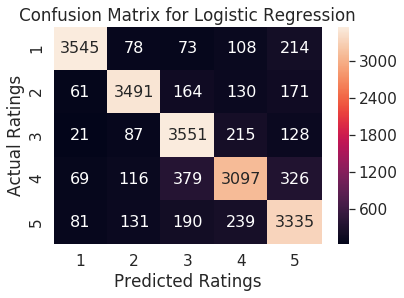

In [0]:
       
df_cm = pd.DataFrame(cm, range(1,cm.shape[0]+1),range(1,cm.shape[0]+1))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Ratings")
plt.ylabel("Actual Ratings")
plt.show()

From the confusion matrix, we calculate the **Precision, Recall and F1 score** across all the 5 classes. 

$$ Precision = \frac{TP}{TP +FP} $$

$$ Recall = \frac{TP}{TP +FN} $$

$$ F1 = \frac{2 * Precision * Recall}{Precision + Recall} $$

In [0]:
cm_results = pd.DataFrame(np.column_stack([f1_scores, p_scores, r_scores]), columns=['F1 Score', 'Precision', 'Recall'], 
                          index=['Star Rating 1', 'Star Rating 2', 'Star Rating 3','Star Rating 4','Star Rating 5'])
print("Confusion Matrix of Logistic Regression")
display(cm_results)

Confusion Matrix of Logistic Regression


,F1 Score,Precision,Recall
Star Rating 1,0.909557,0.938576,0.882280
Star Rating 2,0.881566,0.894440,0.869057
Star Rating 3,0.849623,0.815010,0.887306
Star Rating 4,0.796553,0.817366,0.776775
Star Rating 5,0.818405,0.798994,0.838783


**Interpreting the Confusion Matrix**

From the above confusion matrix, we see that Logistic Regression did very well in 1 star ratings but kept reducing its F1 score in subsequent classes. This suggests that the classifier finds it difficult to differentiate between the higher star ratings. From the confusion matrix it is evident that classifier has a high misclassification rate for **Star Rating 4** and frequently guessed Rating 3 or 5 instead of 4. 

**Future Scope**

The future scope of the project is to work on improving the accuracy for the higher star ratings (ratings 3,4 and 5) and doing more feature engineering to come up with better features. 

Thank you for your time and patience. You are a star! :P (Actually, you are 5 stars!) 